In [23]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(car)
    library(glmnet)
    library(caret)
    library(broom)
    library(pROC)
})

In [24]:
data_url <- "https://raw.githubusercontent.com/audracornick/STAT301_Group24/main/online_shoppers_intention.csv"

OSPI <- read_csv(data_url)

head(OSPI)

Rows: 12330 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Month, VisitorType
dbl (14): Administrative, Administrative_Duration, Informational, Informatio...
lgl  (2): Weekend, Revenue

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>
0,0,0,0,1,0.000000,0.20000000,0.2000000,0,0,Feb,1,1,1,1,Returning_Visitor,FALSE,FALSE
0,0,0,0,2,64.000000,0.00000000,0.1000000,0,0,Feb,2,2,1,2,Returning_Visitor,FALSE,FALSE
0,0,0,0,1,0.000000,0.20000000,0.2000000,0,0,Feb,4,1,9,3,Returning_Visitor,FALSE,FALSE
0,0,0,0,2,2.666667,0.05000000,0.1400000,0,0,Feb,3,2,2,4,Returning_Visitor,FALSE,FALSE
0,0,0,0,10,627.500000,0.02000000,0.0500000,0,0,Feb,3,3,1,4,Returning_Visitor,TRUE,FALSE
0,0,0,0,19,154.216667,0.01578947,0.0245614,0,0,Feb,2,2,1,3,Returning_Visitor,FALSE,FALSE


In [25]:
OSPI_clean <- OSPI %>%
  filter(Region != 1) %>%
  mutate(
    Revenue = as.factor(Revenue),
    Month = as.factor(Month),
    VisitorType = as.factor(VisitorType),
    Weekend = as.factor(Weekend),
    SpecialDay = as.factor(SpecialDay),
    Browser = as.factor(Browser),
    TrafficType = as.factor(TrafficType),
    OperatingSystems = as.factor(OperatingSystems),
    Region         = as.factor(Region)
  ) %>%
  drop_na()

# Quick check
summary(OSPI_clean)

 Administrative   Administrative_Duration Informational    
 Min.   : 0.000   Min.   :   0.00         Min.   : 0.0000  
 1st Qu.: 0.000   1st Qu.:   0.00         1st Qu.: 0.0000  
 Median : 1.000   Median :  10.00         Median : 0.0000  
 Mean   : 2.343   Mean   :  81.56         Mean   : 0.4771  
 3rd Qu.: 4.000   3rd Qu.:  97.46         3rd Qu.: 0.0000  
 Max.   :27.000   Max.   :2156.17         Max.   :14.0000  
                                                           
 Informational_Duration ProductRelated   ProductRelated_Duration
 Min.   :   0.00        Min.   :  0.00   Min.   :    0.0        
 1st Qu.:   0.00        1st Qu.:  7.00   1st Qu.:  189.8        
 Median :   0.00        Median : 18.00   Median :  603.1        
 Mean   :  32.69        Mean   : 30.42   Mean   : 1143.2        
 3rd Qu.:   0.00        3rd Qu.: 37.00   3rd Qu.: 1448.9        
 Max.   :2252.03        Max.   :584.00   Max.   :24844.2        
                                                                


In [26]:
set.seed(123)

# Split into training (80%) and testing (20%)
train_index <- createDataPartition(OSPI_clean$Revenue, p = 0.8, list = FALSE)
train_data <- OSPI_clean[train_index, ]
test_data  <- OSPI_clean[-train_index, ]

# Create model matrices for glmnet (numeric inputs)
x_train <- model.matrix(
  Revenue ~ .,
  data = train_data
)[, -1]

x_test <- model.matrix(
  Revenue ~ .,
  data = test_data
)[, -1]

y_train <- as.numeric(train_data$Revenue) - 1
y_test  <- as.numeric(test_data$Revenue) - 1

[1] 0.03562836

71 x 1 sparse Matrix of class "dgCMatrix"
                                        s1
(Intercept)                  -2.1352666255
Administrative                .           
Administrative_Duration       .           
Informational                 .           
Informational_Duration        .           
ProductRelated                .           
ProductRelated_Duration       0.0000154665
BounceRates                   .           
ExitRates                    -2.0803779657
PageValues                    0.0529494908
SpecialDay0.2                 .           
SpecialDay0.4                 .           
SpecialDay0.6                 .           
SpecialDay0.8                 .           
SpecialDay1                   .           
MonthDec                      .           
MonthFeb                      .           
MonthJul                      .           
MonthJune                     .           
MonthMar                      .           
MonthMay                      .           
MonthNov    

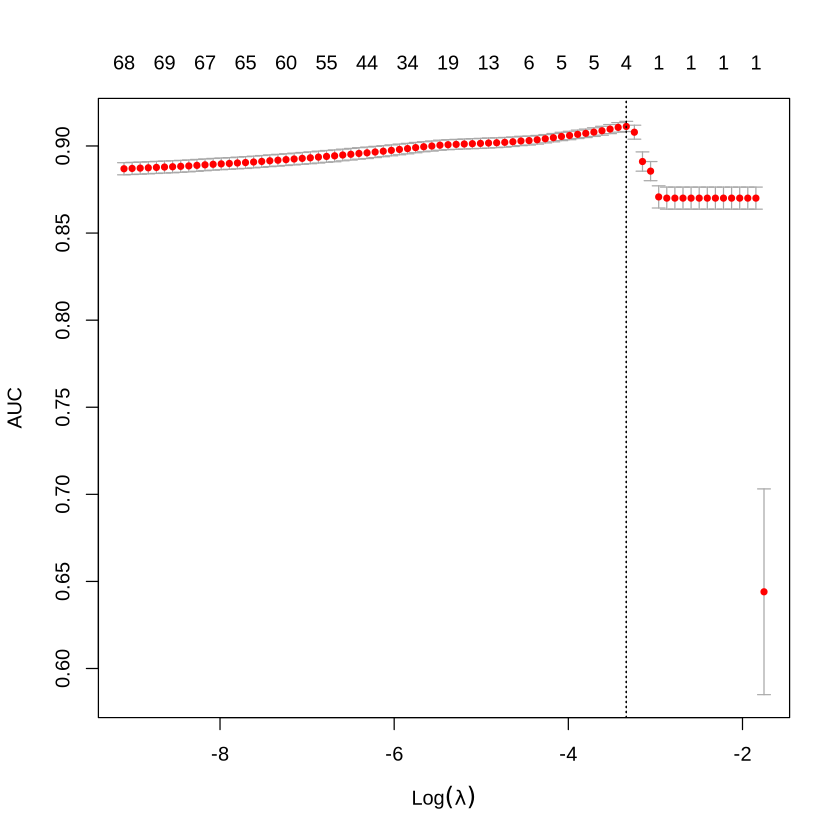

In [53]:
set.seed(123)

cv_lasso <- cv.glmnet(
  x = x_train,
  y = y_train,
  family = "binomial",
  alpha = 1,     
  nfolds = 10,
  type.measure = "auc"
)


plot(cv_lasso)

lambda_min  <- cv_lasso$lambda.min

lambda_min

coef_lasso_min  <- coef(cv_lasso, s = "lambda.min")
coef_lasso_1se  <- coef(cv_lasso, s = "lambda.1se")

coef_lasso_min

p_test_hat <- predict(
  cv_lasso,
  newx = x_test,
  s = "lambda.min",
  type = "response"
)

In [56]:
roc_obj <- roc(response = y_test, predictor = as.numeric(p_test_hat))

best_coords <- coords(
  roc_obj,
  x = "best",
  best.method = "youden",
  transpose = TRUE
)
 
best_thresh <- best_coords["threshold"]
best_thresh

Setting levels: control = 0, case = 1

Setting direction: controls < cases



threshold 
0.1195171

In [57]:
y_test_factor <- factor(y_test, levels = c(0, 1))
y_pred_best   <- factor(as.numeric(p_test_hat > best_thresh), levels = c(0, 1))

cm <- confusionMatrix(
  data      = y_pred_factor,
  reference = y_test_factor,
  positive  = "1"
)

cm 

# Extract metrics
accuracy    <- cm$overall["Accuracy"]
kappa       <- cm$overall["Kappa"]

sensitivity <- cm$byClass["Sensitivity"]      
specificity <- cm$byClass["Specificity"]   
precision   <- cm$byClass["Pos Pred Value"]

accuracy
kappa
precision
sensitivity
specificity

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1154   46
         1  128  181
                                          
               Accuracy : 0.8847          
                 95% CI : (0.8675, 0.9004)
    No Information Rate : 0.8496          
    P-Value [Acc > NIR] : 4.695e-05       
                                          
                  Kappa : 0.6073          
                                          
 Mcnemar's Test P-Value : 8.221e-10       
                                          
            Sensitivity : 0.7974          
            Specificity : 0.9002          
         Pos Pred Value : 0.5858          
         Neg Pred Value : 0.9617          
             Prevalence : 0.1504          
         Detection Rate : 0.1199          
   Detection Prevalence : 0.2048          
      Balanced Accuracy : 0.8488          
                                          
       'Positive' Class : 1               
                        

Accuracy 
0.8846918

Kappa 
0.6072534

Pos Pred Value 
     0.5857605

Sensitivity 
  0.7973568

Specificity 
   0.900156

Setting levels: control = 0, case = 1

Setting direction: controls < cases



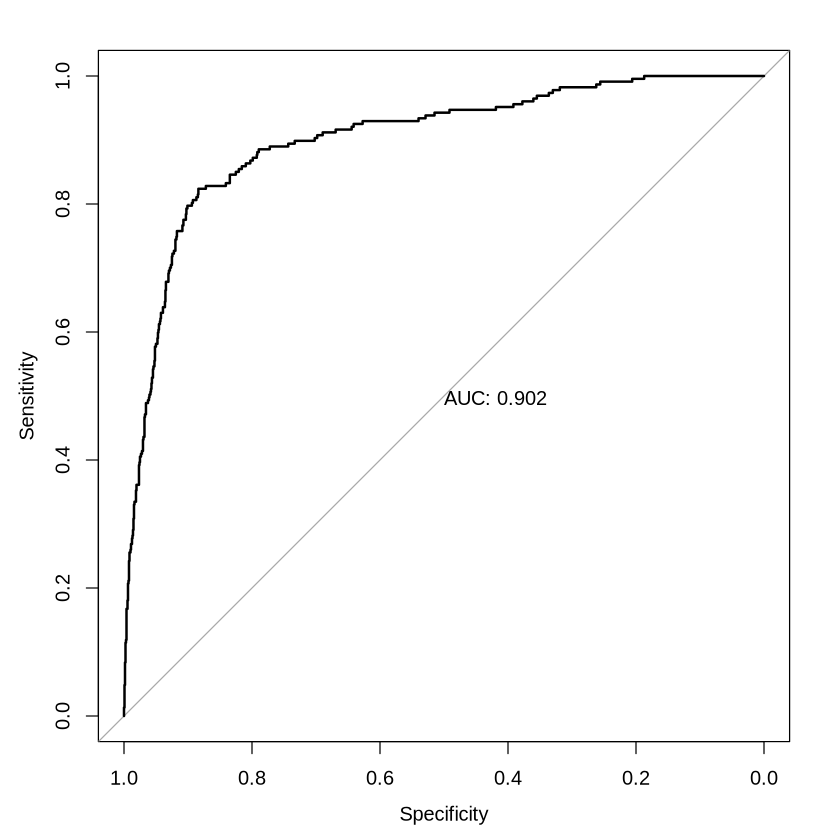

In [58]:
roc_lasso <- roc(
  response  = y_test,
  predictor = as.numeric(p_test_hat)
)

plot(roc_lasso, print.auc = TRUE)